In [1]:
import random
random.seed()

def get_alphabet(word_list)-> str:
	alphabet = set()
	for w in word_list:
		for c in w:
			alphabet.add(c)
	return "".join(alphabet)

def generate_edits(w, alphabet):
	result = []
	for i, c in enumerate(w):
		result.append(w[:i] + w[i + 1:]) # delete
		for l in alphabet:
			result.append(w[:i] + l + w[i:]) # insert
			if c != l:
				result.append(w[:i] + l + w[i + 1:]) # replace

	for l in alphabet: # insert in the end
		result.append(w + l)

	i = 0
	while i + 2 <= len(w): # flip all bigrams
		result.append(w[:i] + w[i+1] + w[i] + w[i+2:])
		i += 1

	return [edit for edit in result if len(result) > 0]

def generate_k_random_candidates(w, k, alphabet) -> list[str]:
	candidates = []
	for e in generate_edits(w, alphabet):
		candidates += generate_edits(e, alphabet)
	return random.choices(candidates, k=k)

In [5]:
import json
from distance import Edit_suggester

with open('data/articles_cleaned_vocabulary.json', 'r', encoding="utf-8") as f:
    dictionary = [d[0] for d in json.load(f)]

alphabet = get_alphabet(dictionary)

edit_suggester = Edit_suggester(2, dictionary)

In [6]:
import time

def test_suggester(jaccard_threshold, suggestion_count, test_word_count) -> tuple[float, float]:
    m = 0
    n = 0
    start = time.time()
    for w in random.choices(dictionary, k = test_word_count):
        for candidate in generate_k_random_candidates(w, suggestion_count, alphabet):
            suggested_word = edit_suggester.ngram_spellcheck(candidate, jaccard_threshold)
            if suggested_word != None and w == suggested_word:
                m += 1
            n += 1
    end = time.time()
    return m/n, (end-start)/n

Larger jaccard threshold means less words to compare against with levenshtein distance.<br>
We will try to find the optimal threshold that gives satisfying results on the suggesting.

In [7]:
suggestion_count = 10
test_word_count = 100
jaccard_thresholds = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.10]
results = []
for j_t in jaccard_thresholds:
    result = test_suggester(j_t, suggestion_count, test_word_count)
    print(result)
    results.append(result)

(0.0, 0.05446283292770386)
(0.0, 0.05402380061149597)
(0.001, 0.044523728609085086)
(0.001, 0.049056531667709354)
(0.001, 0.050379638671875)
(0.004, 0.04216156792640686)
(0.001, 0.047266289710998534)
(0.005, 0.04320336270332337)
(0.023, 0.04330256390571594)
(0.013, 0.04462651777267456)
(0.145, 0.055915741682052614)
(0.338, 0.04750975179672241)
(0.595, 0.05128221535682678)
(0.701, 0.04950923466682434)
(0.751, 0.060781423330307005)
(0.789, 0.107207932472229)
(0.816, 0.2616037151813507)
(0.798, 0.7494765319824219)


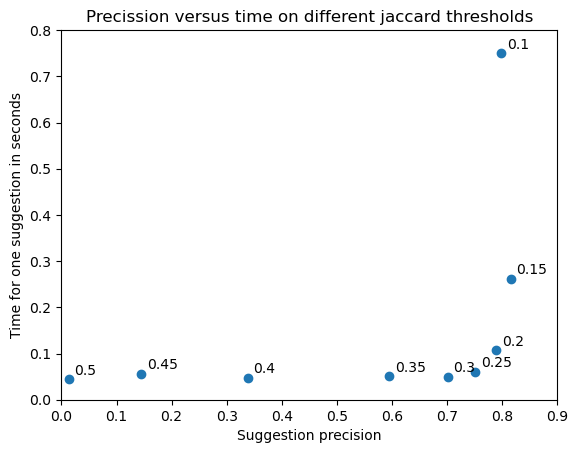

In [9]:
import matplotlib.pyplot as plt

unzipped = list(zip(*results[9:]))

fig, ax = plt.subplots()
ax.scatter(unzipped[0], unzipped[1])

offset = 0.01
for i, txt in enumerate(jaccard_thresholds[9:]):
    ax.annotate(txt, (unzipped[0][i] + offset, unzipped[1][i] + offset))

plt.ylim(0, 0.8)
plt.xlim(0, 0.9)
plt.title("Precission versus time on different jaccard thresholds")
plt.xlabel("Suggestion precision")
plt.ylabel("Time for one suggestion in seconds")
plt.show()

It seems like 0.25 gives best compromise between speed and precision